#**Occupation Extraction and Analysis**

In [1]:
#import libraries
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams
import re
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


#### **Utiltis functions**

In [3]:
def remove_links(tweet):
    return re.sub("(http[s]?:\S+)","", tweet)

def remove_shortwords(tweet):
    tweet=re.sub("'", "", tweet)
    tweet = tweet.split()
    clean_tweet = [word for word in tweet if  len(word) > 1]
    return " ".join(clean_tweet)


def remove_mentions(tweet):
    '''@User Mention'''
    return re.sub("@[A-Za-z0-9_]+","", tweet)


def remove_stopwords(tweet):
    stopwords_list = stopwords.words('english')
    tweet = tweet.split()
    clean_tweet = [word for word in tweet if (word not in stopwords_list)]
    return " ".join(clean_tweet)

def remove_nonwords(tweet):
    tweet = re.sub('[^\w]',' ',tweet)
    return tweet

def clean_text(tweet):
    tweet = remove_links(tweet)
    tweet = remove_mentions(tweet)
    tweet = tweet.lower()
    tweet = remove_stopwords(tweet)
    tweet = remove_nonwords(tweet)
    tweet = remove_shortwords(tweet)
    tweet = tweet.strip()
    return tweet

def get_unigrams_bigrams(text):
    tokens = text.split()
    unigrams = tokens
    bigrams = [' '.join(bg) for bg in ngrams(tokens, 2) if len(tokens) >= 2]  # Ensure there are enough tokens for bigrams
    return set(unigrams + bigrams)

In [4]:
# reading Data
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ChatGPT.csv')


<ipython-input-4-d3aa6f4ab681>:2: DtypeWarning: Columns (0,6,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ChatGPT.csv')


In [5]:
df.head()

,Unnamed: 0,Date,Tweet,Url,User,UserCreated,UserVerified,UserFollowers,UserFriends,Retweets,Likes,Location,Description
0,0,2023-04-08 03:33:13+00:00,#ChatGPT If only there were a movie or somethi...,https://twitter.com/kirbydjohnson/status/16445...,kirbydjohnson,2012-07-29 22:57:46+00:00,False,50.0,76.0,0.0,0,NaN,NaN
1,1,2023-04-08 03:32:16+00:00,"Workshop Description: In this workshop, you wi...",https://twitter.com/UniversityWeb/status/16445...,UniversityWeb,2013-01-13 20:18:16+00:00,False,9056.0,387.0,0.0,0,NaN,"University webinars, speech videos, & news for..."
2,2,2023-04-08 03:32:05+00:00,New Post at AiNewsDrop!\n\nChatGPT is a doctor...,https://twitter.com/AiNewsDrop/status/16445436...,AiNewsDrop,2022-01-19 06:25:45+00:00,False,276.0,313.0,0.0,0,NaN,I'm up almost 24/7 hunting for AI News\n\nWith...
3,3,2023-04-08 03:31:08+00:00,OpenAI’s GPT-4 Just Got Supercharged! #ai #Cha...,https://twitter.com/tubeblogger/status/1644543...,tubeblogger,2013-06-25 01:42:59+00:00,False,312.0,293.0,0.0,0,The Internet,"Exploring the Best Of The Web. Tech, Games, Ar..."
4,4,2023-04-08 03:30:51+00:00,"""Classical art"" is struggling - not changed th...",https://twitter.com/majorradic/status/16445432...,majorradic,2011-12-12 01:29:15+00:00,False,522.0,684.0,0.0,2,Beograd Navodni,Mediji i milosrdje\n\n ...


In [6]:
df1 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/job_descriptions.csv")

In [7]:
#make subset easy to interpret
job=df1[['Job Description','Job Title']]
text=df[['Description']]

In [8]:
#check for null values
text.isnull().sum()

Description    22963
dtype: int64

In [9]:
# Remove missing values
text = text.dropna()
print("Length: ",len(text))

Length:  455384


In [13]:
#check for duplicates
text.duplicated().sum()
job.duplicated().sum()

271046

In [14]:
# Drop duplicate rows, keeping the first occurrence
text= text.drop_duplicates()
job= job.drop_duplicates()

In [16]:
#adjust datasets Index
text['Index'] = text.index
df = df.rename(columns={'Unnamed: 0': 'Index'})
df = df.set_index('Index')

In [20]:
# Preprocess descriptions
text['cleaned_description'] =text['Description'].apply(clean_text)
job['cleaned_job_description'] = job['Job Description'].apply(clean_text)


In [21]:
# Generate Unigrams and Bigrams
text['unigrams_bigrams'] = text['cleaned_description'].apply(get_unigrams_bigrams)
job['job_unigrams_bigrams'] = job['cleaned_job_description'].apply(get_unigrams_bigrams)


In [22]:
def match_occupations(unigrams_bigrams_set, occupation_unigrams_bigrams_dict):
    for occupation, unigrams_bigrams in occupation_unigrams_bigrams_dict.items():
        if unigrams_bigrams_set & unigrams_bigrams:  # Check for intersection
            return occupation  # Return the first match found
    return "Not Found"  # Return "Not Found" if no match is found


In [23]:
# Create a dict of occupations and their unigrams_bigrams for easier matching
occupation_unigrams_bigrams = job.set_index('Job Title')['job_unigrams_bigrams'].to_dict()


In [24]:
# Apply matching for each user
text['matched_occupations'] = text['unigrams_bigrams'].apply(lambda x: match_occupations(x, occupation_unigrams_bigrams))


In [31]:
text

,Description,Index,cleaned_description,unigrams_bigrams,matched_occupations
1,"University webinars, speech videos, & news for...",1,university webinars speech videos news leaders...,"{blog, blog list, top higher, speech videos, u...",Social Media Coordinator
2,I'm up almost 24/7 hunting for AI News\n\nWith...,2,almost 24 hunting ai news intellect guide ll a...,"{what right, world, intellect, leaving mark, w...",Teacher
3,"Exploring the Best Of The Web. Tech, Games, Ar...",3,exploring best web tech games art weirdtubes c...,"{weirdtubes comedy, games art, comedy music, e...",Web Developer
4,Mediji i milosrdje\n\n ...,4,mediji milosrdje moralno preispitivanje sport,"{moralno preispitivanje, preispitivanje, preis...",Not Found
5,The official technology news website of The Ti...,5,official technology news website times india g...,"{tech media, us things, india follow, gadgets,...",Social Media Coordinator
...,...,...,...,...,...
478315,coder();,478315,coder,{coder},Not Found
478324,Secular transhumanist and Ernest Shackleton st...,478324,secular transhumanist ernest shackleton stan a...,"{building, angel, ai stuff, longevity, active,...",Office Manager
478329,KD9TWC - AFOL - LDS - former strength athlete ...,478329,kd9twc afol lds former strength athlete miss o...,"{opinions, chum opinions, miss, chum, old chum...",Not Found
478330,I work in an embedded space #btc,478330,work embedded space btc,"{work, embedded, btc, work embedded, space btc...",Web Developer


#**Get occupations distriputions**

In [33]:
# Discriptions without occupation
empty_lists_count = text['matched_occupations'].apply(lambda x: x == 'Not Found').sum()

In [34]:
empty_lists_count

47759

<ipython-input-47-d4cd3929a225>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_occupation_counts.head(20), x='Count', y='Occupations', palette='viridis')  # Adjust 'head(20)' to display more or fewer occupations


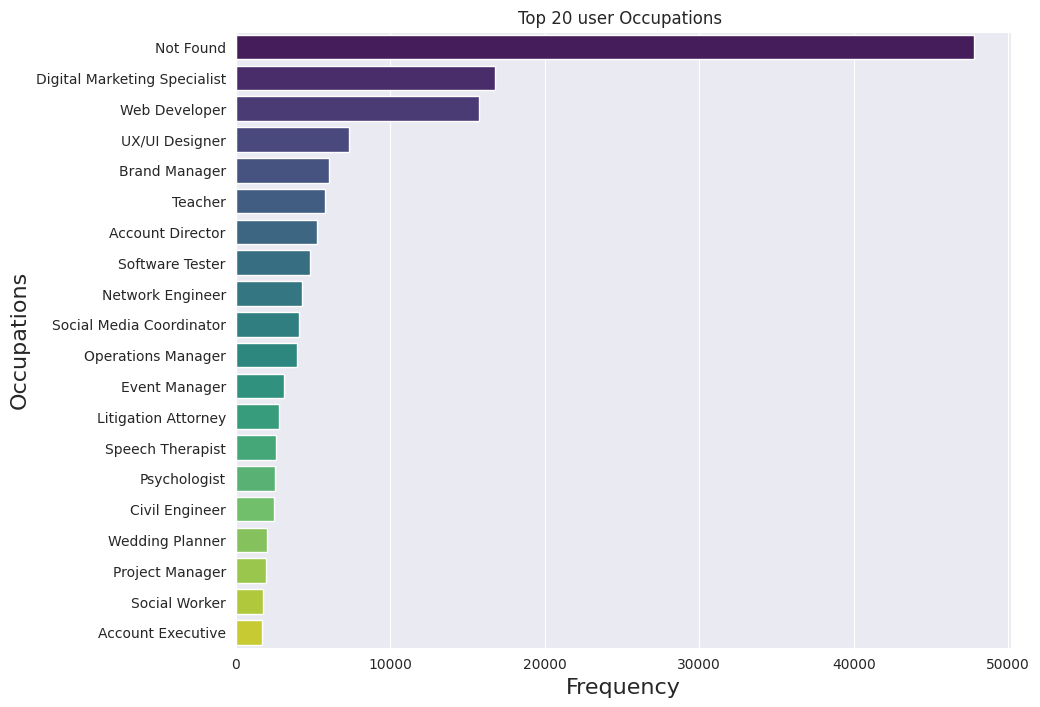

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set seaborn style
sns.set_style('darkgrid')

# Directly count the occurrences of each occupation
occupation_counts = text['matched_occupations'].value_counts()

# Convert the Series object to a DataFrame for easier plotting
df_occupation_counts = pd.DataFrame({'Occupations': occupation_counts.index, 'Count': occupation_counts.values})

# Now you can plot using seaborn or matplotlib as you like
# For instance, using seaborn to create a bar plot
plt.figure(figsize=(10, 8))
sns.barplot(data=df_occupation_counts.head(20), x='Count', y='Occupations', palette='viridis')  # Adjust 'head(20)' to display more or fewer occupations
plt.title('Top 20 user Occupations ')
plt.xlabel('Frequency',fontsize=16)
plt.ylabel('Occupations',fontsize=16)
plt.show()


In [36]:
df_occupation_counts

,Occupations,Count
0,Not Found,47759
1,Digital Marketing Specialist,16777
2,Web Developer,15740
3,UX/UI Designer,7357
4,Brand Manager,6061
...,...,...
138,Project Coordinator,3
139,Pharmaceutical Sales Representative,3
140,Marketing Specialist,2
141,Marketing Analyst,1


##Map ocupations to general fileds :

In [37]:
# Provided mapping of specific occupations to fields
occupation_to_field = {
    'Web Developer': 'Computer and Technology',
    'Art Teacher': 'Teaching',
    'Front-End Engineer': 'Computer and Technology',
    'Social Media Coordinator': 'Arts and Entertainment',
    'Art Director': 'Arts and Entertainment',
    'Software Tester': 'Computer and Technology',
    'UX/UI Designer': 'Computer and Technology',
    'Teacher': 'Teaching',
    'Account Director': 'Business and Finance',
    'Sales Consultant': 'Sales',
    'Family Nurse Practitioner': 'Healthcare',
    'Structural Engineer': 'Engineering',
    'QA Analyst': 'Computer and Technology',
    'Brand Manager': 'Business and Finance',
    'Java Developer': 'Computer and Technology',
    'Office Manager': 'Business and Finance',
    'SEO Specialist': 'Computer and Technology',
    'Research Scientist': 'Research',
    'Scientist': 'Research',
    'Research Analyst': 'Research',
}

# Function to map a single occupation to its field
def get_field_from_occupation(occupation):
    return occupation_to_field.get(occupation, "Other")

# Function to map a list of occupations to their fields
def get_fields_from_occupations(occupations_list):
    if isinstance(occupations_list, list):
        return [get_field_from_occupation(occupation) for occupation in occupations_list]
    else:
        return get_field_from_occupation(occupations_list)


In [38]:
# Apply the mapping to the 'occupations' column
text['general_fields'] = text['matched_occupations'].apply(get_fields_from_occupations)

In [40]:
text.head()

,Description,Index,cleaned_description,unigrams_bigrams,matched_occupations,general_fields
1,"University webinars, speech videos, & news for...",1,university webinars speech videos news leaders...,"{blog, blog list, top higher, speech videos, u...",Social Media Coordinator,Arts and Entertainment
2,I'm up almost 24/7 hunting for AI News\n\nWith...,2,almost 24 hunting ai news intellect guide ll a...,"{what right, world, intellect, leaving mark, w...",Teacher,Teaching
3,"Exploring the Best Of The Web. Tech, Games, Ar...",3,exploring best web tech games art weirdtubes c...,"{weirdtubes comedy, games art, comedy music, e...",Web Developer,Computer and Technology
4,Mediji i milosrdje\n\n ...,4,mediji milosrdje moralno preispitivanje sport,"{moralno preispitivanje, preispitivanje, preis...",Not Found,Other
5,The official technology news website of The Ti...,5,official technology news website times india g...,"{tech media, us things, india follow, gadgets,...",Social Media Coordinator,Arts and Entertainment


#  Get the top fileds


In [50]:
fields_count = text['general_fields'].value_counts()

# Threshold for combining small slices into 'Other'
threshold = 0.03  # 3%
other = fields_count[fields_count / fields_count.sum() < threshold].sum()
fields_count_aggregated = fields_count[fields_count / fields_count.sum() >= threshold]
fields_count_aggregated['Other'] = other  # Add 'Other' category



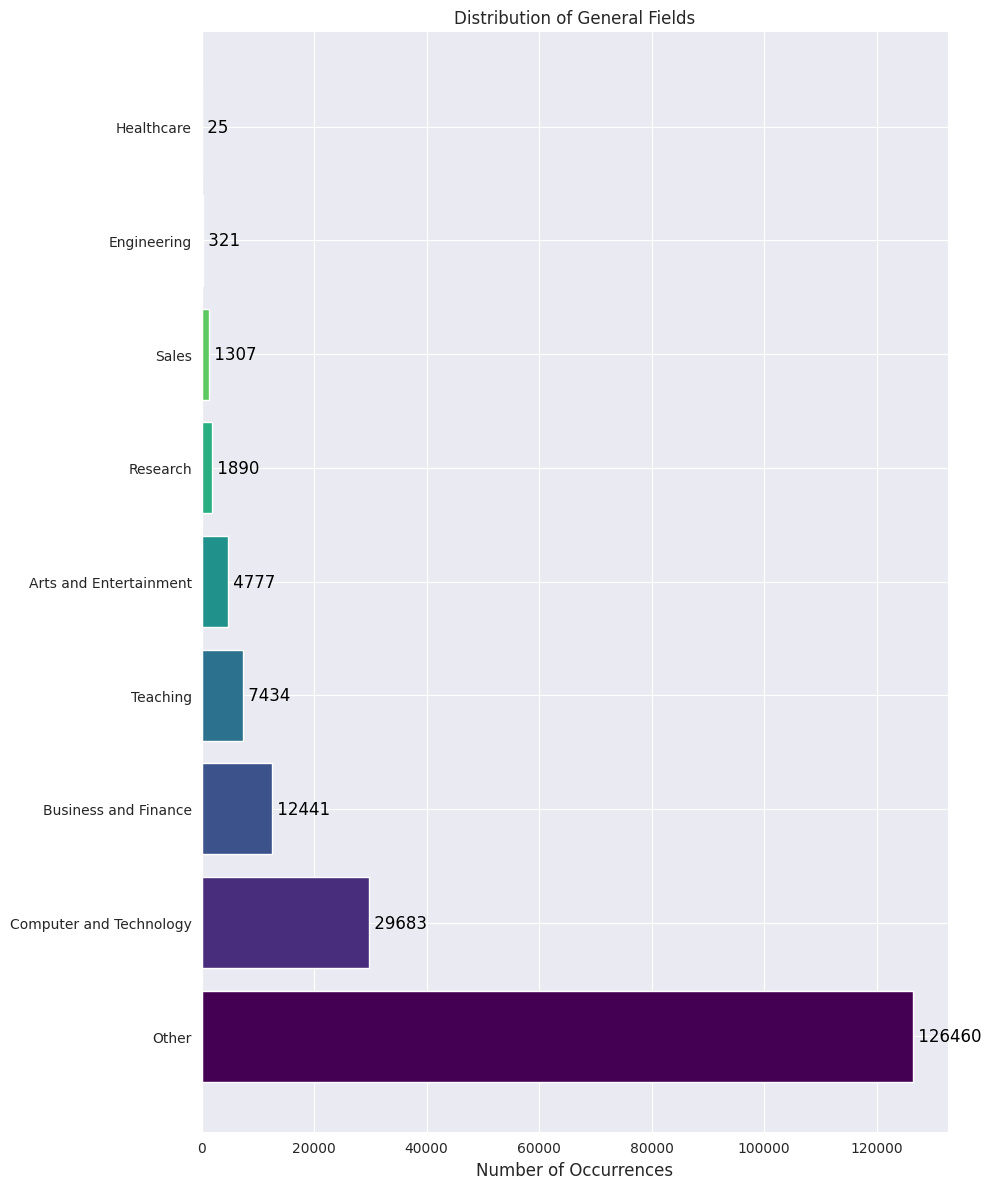

In [80]:
# Assuming fields_count_aggregated is your Series with field counts; if not, replace it with fields_count or your original data
fields_count_aggregated = fields_count_aggregated.sort_values()  # Sort values for better visualization

# Plotting
plt.figure(figsize=(10, 12))
bars = plt.barh(fields_count.index, fields_count.values, color=plt.cm.viridis(np.linspace(0, 1, len(fields_count))))

plt.xlabel('Number of Occurrences', fontsize=12)
plt.title('Distribution of General Fields', fontsize=12)

# Add text labels to the right end of each bar
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2,
             f' {bar.get_width()}',
             va='center', ha='left', fontsize=12, color='black')

plt.tight_layout()  # Adjust layout to make room for the bar labels
plt.show()

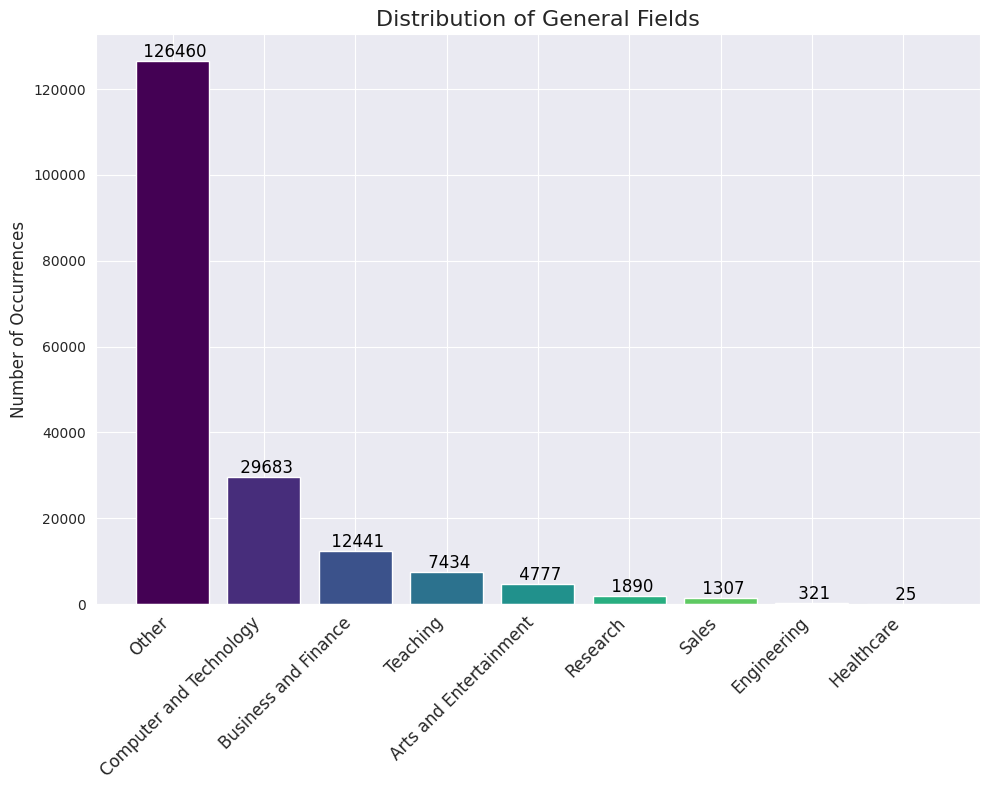

In [83]:
# Make sure to sort the filtered data for better visualization
fields_count = text['general_fields'].value_counts()

# Plotting
plt.figure(figsize=(10, 8))  # Adjust figure size as needed
bars = plt.bar(fields_count.index, fields_count.values, color=plt.cm.viridis(np.linspace(0, 1, len(fields_count))))

plt.ylabel('Number of Occurrences', fontsize=12)  # Adjusted for vertical bars
plt.xticks(rotation=45, ha='right', fontsize=12)  # Rotate x labels to fit and prevent overlap
plt.title('Distribution of General Fields', fontsize=16)

# Add text labels above each bar
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
             f' {bar.get_height()}',
             ha='center', va='bottom', fontsize=12, color='black')

plt.tight_layout()
plt.show()


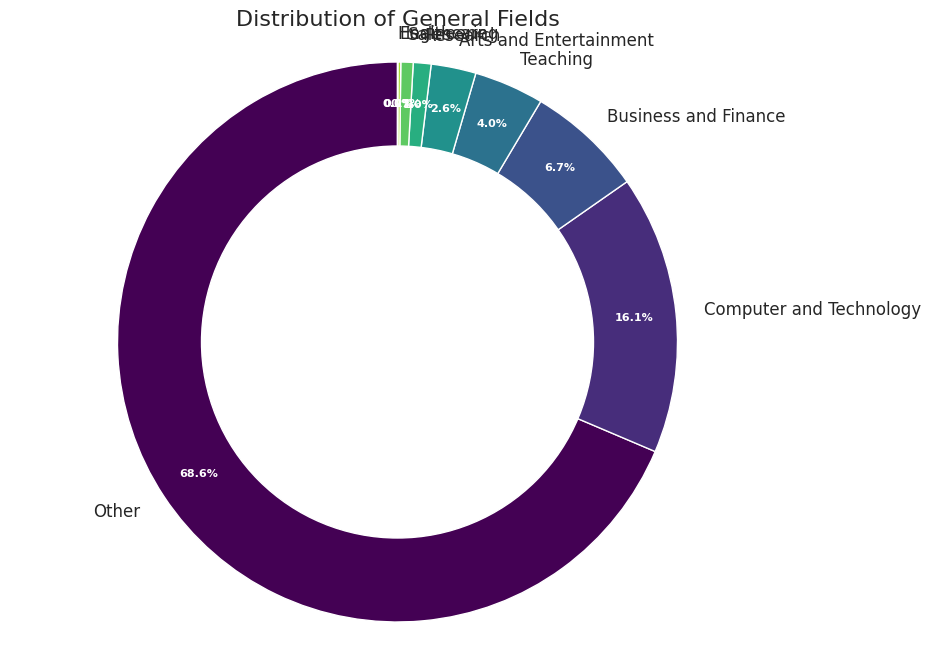

In [63]:
import matplotlib.pyplot as plt

# Sorting the data can sometimes help with readability
fields_count_aggregated = fields_count.sort_values(ascending=False)

# Generate a color palette
colors = plt.cm.viridis(np.linspace(0, 1, len(fields_count_aggregated)))

# Plotting
plt.figure(figsize=(10, 8))  # Larger figure size for better visibility
wedges, texts, autotexts = plt.pie(fields_count_aggregated, labels=fields_count_aggregated.index, autopct='%1.1f%%', startangle=90, colors=colors, pctdistance=0.85)

# Draw a circle at the center to turn the pie into a donut
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures the pie chart is circular
plt.axis('equal')

# Enhance the text properties and pie chart appearance
plt.setp(texts, size=12)  # Reduce the size of the text labels to fit small slices
plt.setp(autotexts, size=8, weight="bold", color="white")  # Adjust the size and color of the autopct texts to make them stand out

plt.title('Distribution of General Fields', fontsize=16)
plt.show()


In [70]:
total_counts = fields_count_aggregated.sum()
fields_percentage = (fields_count_aggregated / total_counts) * 100
filtered_fields = fields_percentage[fields_percentage > 0.3]


In [73]:
fields_count_aggregated.head()

Other                      71.844925
Computer and Technology    16.863616
Business and Finance        7.068027
Teaching                    4.223432
Name: general_fields, dtype: float64

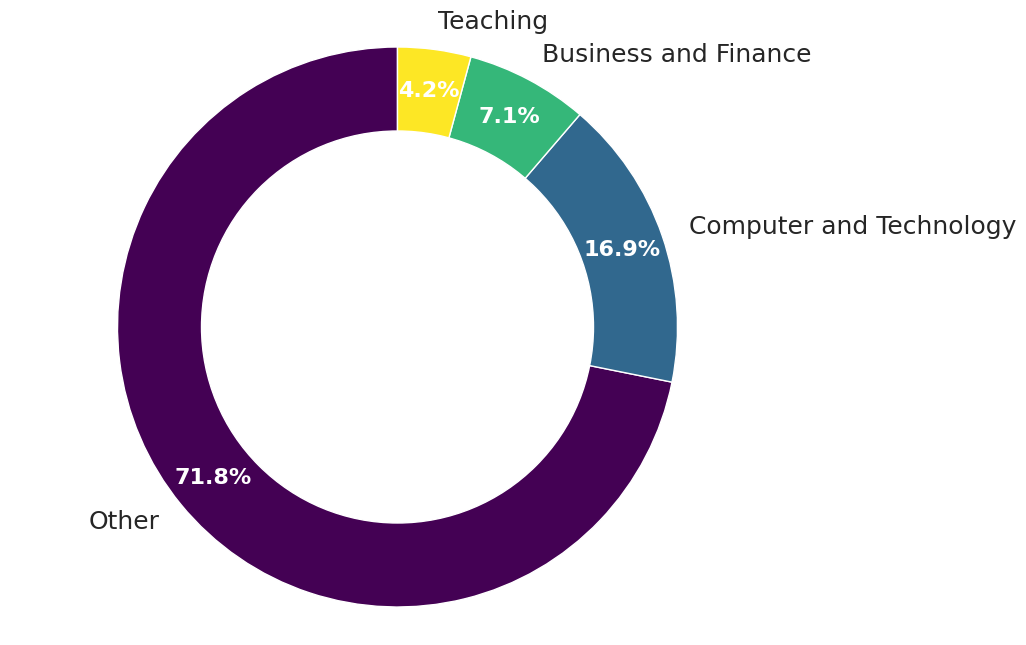

In [86]:

# Sorting the data can sometimes help with readability
fields_count_aggregated = filtered_fields.sort_values(ascending=False)

# Generate a color palette
colors = plt.cm.viridis(np.linspace(0, 1, len(filtered_fields)))

# Plotting
plt.figure(figsize=(10, 8))  # Larger figure size for better visibility
wedges, texts, autotexts = plt.pie(fields_count_aggregated, labels=fields_count_aggregated.index, autopct='%1.1f%%', startangle=90, colors=colors, pctdistance=0.85)

# Draw a circle at the center to turn the pie into a donut
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures the pie chart is circular
plt.axis('equal')

# Enhance the text properties and pie chart appearance
plt.setp(texts, size=18)  # Reduce the size of the text labels to fit small slices
plt.setp(autotexts, size=16, weight="bold", color="white")  # Adjust the size and color of the autopct texts to make them stand out


plt.show()
